**User Input and Image Generation**

Steps with Gradio:
1. Ask User for Image Concepts: Use Gradio to create a text input interface where users can enter their image concepts.
2. Clean User Input: Ensure the prompt is clean of unnecessary spaces or characters.
3. Prompt the Image Generation Agent: Call APIs to generate images using Stable Diffusion XL and DALL-E based on user input.

In [1]:
# Import Dependencies

# For environment variables
import os
from dotenv import load_dotenv

# For dataframes
import pandas as pd

# For API calls
import requests
import openai

# For image processing and viewing
import base64
import io
from PIL import Image
import matplotlib.pyplot as plt

# For UI
import gradio as gr

# For caption generation
from transformers import BlipProcessor, BlipForConditionalGeneration

# Load dependencies to measure text output
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu

import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import common_functions as functions

In [2]:
# Load environment variables.
load_dotenv()

# Store the API key in a variable.
openai.api_key = os.getenv("OPENAI_API_KEY")
STABILITY_AI_API_KEY = os.getenv("STABILITY_AI_API_KEY")

In [3]:
# Utility to view images for debugging
def view_base64_image(base64_string):
    """Decodes a base64 encoded image and displays it using matplotlib."""

    # Decode the base64 string
    image_data = base64.b64decode(base64_string)

    # Open the image using PIL
    image = Image.open(io.BytesIO(image_data))

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [4]:
# Call Stability AI API and generate an image
def generate_stability_ai_image(prompt):
    host = 'https://api.stability.ai/v2beta/stable-image/generate/sd3'
    params = {
        "prompt" : prompt,
        "negative_prompt" : '',
        "aspect_ratio" : '1:1',
        "seed" : 0,
        "output_format" : 'jpeg',
        "model" : "sd3",
        "mode" : "text-to-image"
    }
    headers = {
        "Accept": "image/*",
        "Authorization": f"Bearer {STABILITY_AI_API_KEY}"
    }

    # Encode parameters
    files = {}
    image = params.pop("image", None)
    mask = params.pop("mask", None)
    if image is not None and image != '':
        files["image"] = open(image, 'rb')
    if mask is not None and mask != '':
        files["mask"] = open(mask, 'rb')
    if len(files)==0:
        files["none"] = ''

    # Send request
    print(f"Sending REST request to {host}...")
    response = requests.post(
        host,
        headers=headers,
        files=files,
        data=params
    )
    if not response.ok:
        raise Exception(f"HTTP {response.status_code}: {response.text}")

    return base64.b64encode(response.content)
    # To test the function: response = generate_stability_ai_image("cute shiba inu")


In [5]:
# Call Dall-E Open AI API and generate an image
def call_dalle_api(prompt):
    client = openai.OpenAI()
    response = client.images.generate(
    model="dall-e-2",
    prompt=prompt,
    size="512x512",
    quality="standard",
    n=1,
    response_format="b64_json"
    )

    return response.data[0].b64_json
    # To test the function: response = call_dalle_api("A realistic image of a shiba inu with a birthday hat on the street")

In [6]:
# Generate images and assess their quality
def generate_images_with_quality(prompt):
    unique_id = functions.generate_hash(prompt, algorithm='md5')

    cleaned_prompt = functions.clean_user_input(prompt)
    stability_ai_image = functions.base64_to_pil_image(generate_stability_ai_image(cleaned_prompt))
    dalle_image = functions.base64_to_pil_image(call_dalle_api(cleaned_prompt))
        
    with open(f"generated_images/{unique_id}_prompt.txt", "w") as f:
        # Write text to the file
        f.write(f'{prompt}, {cleaned_prompt}')
        
    stability_ai_image.save(f'generated_images/{unique_id}_stability_ai.jpg')
    dalle_image.save(f'generated_images/{unique_id}_dalle.jpg')

    #sd_quality = assess_image_quality(sd_image)
    #dalle_quality = assess_image_quality(dalle_image)
    return stability_ai_image, dalle_image, 'stability_ai' #, f"Quality: {sd_quality}", dalle_image, f"Quality: {dalle_quality}"

In [7]:
# Produce output
def create_image_record(prompt, user_preference):
    unique_id = functions.generate_hash(prompt, algorithm='md5')        
    file_output = open('image_generation_results.csv', 'a')
    file_output.write(f'"{unique_id}","{prompt}","","","","","","","{user_preference}"\r\n')
    file_output.close()

In [8]:
def prefer_stability_ai(param):
    create_image_record(param, 'stability_ai')

def prefer_dalle(param):
    create_image_record(param, 'dall-e')

# Create the Gradio interface using Blocks
with gr.Blocks() as demo:
    gr.Markdown("# Text-to-Image Generation")
    gr.Markdown("Input a prompt to generate images using Stability AI and Dall-E.")

    # Input component for text concept
    concept_input = gr.Textbox(label="Enter Image Prompt", placeholder="Describe the image...")

    # Create a submit button
    generate_button = gr.Button("Generate Images")

    winner = gr.Label()

    # Output components for displaying images
    stability_output = gr.Image(type="pil", label="Stability AI Image")
    dalle_output = gr.Image(type="pil", label="Dall-E Image")

    stability_ai_button = gr.Button("I like Stability AI image")
    stability_ai_button.click(
        fn=prefer_stability_ai, 
        inputs=[concept_input],
        outputs=[]
    )    

    dalle_button = gr.Button("I like Dall-E image")
    dalle_button.click(
        fn=prefer_dalle, 
        inputs=[concept_input],
        outputs=[]
    )    

    # Button click event to generate images
    generate_button.click(
        fn=generate_images_with_quality, 
        inputs=concept_input, 
        outputs=[stability_output, dalle_output, winner]
    )

# Launch the interface
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://03d4fb122d686363a2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**Image Evaluation, Relevance Check, and Description Generation**

Steps:
1. Evaluate Image Relevance: Use an LLM to assess whether the generated image is relevant to the prompt.
2. Generate Image Descriptions: Use a classifier to create descriptive summaries of the images.
3. Compare Models: Analyze how each model's output aligns with the user query.

In [9]:
# Load the pre-trained model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/opt/anaconda3/envs/dev/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [10]:
# Function for caption generation
def generate_caption(image):
    # Process the image and generate a caption
    inputs = processor(images=image, return_tensors="pt")
    out = model.generate(**inputs)
    caption = processor.decode(out[0], skip_special_tokens=True)
    return caption

In [11]:
# Function to calculate Rouge score
def calculate_rouge(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, generated)
    return scores

In [12]:
# This function calculates scores for the models and saves back to the results file
def process_image_record(record_id):
    # Load prompt for images
    prompt_file = open(f'generated_images/{record_id}_prompt.txt')
    prompt = prompt_file.read().split(',')[1]

    # Generate caption for Stability AI image
    img = Image.open(f"generated_images/{record_id}_stability_ai.jpg")
    stability_ai_caption = generate_caption(img)

    # Generate caption for Dall-E image
    img = Image.open(f"generated_images/{record_id}_dalle.jpg")
    dalle_caption = generate_caption(img)

    # Generate Stability AI BLEU score
    # Prompted captions and generated captions
    reference_captions = [prompt]
    generated_captions = [stability_ai_caption]

    # Calculate BLEU scores for each pair of reference and generated captions
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate the average BLEU score
    stability_ai_bleu = sum(bleu_scores) / len(bleu_scores)

    # Print the average BLEU score
    print(f"Average BLEU Score: {stability_ai_bleu:.4f}")

    # Generate Dall-E BLEU score
    # Prompted captions and generated captions
    reference_captions = [prompt]
    generated_captions = [dalle_caption]

    # Calculate BLEU scores for each pair of reference and generated captions
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate the average BLEU score
    dalle_bleu = sum(bleu_scores) / len(bleu_scores)

    # Print the average BLEU score
    print(f"Average BLEU Score: {dalle_bleu:.4f}")

    # Generate Stability AI ROUGE Score
    reference_captions = [prompt]
    generated_captions = [stability_ai_caption]
    for ref, gen in zip(reference_captions, generated_captions):
        stability_ai_rouge_score = calculate_rouge(ref, gen)
        print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {stability_ai_rouge_score}")

    # Generate Dall-E ROUGE Score
    reference_captions = [prompt]
    generated_captions = [dalle_caption]
    for ref, gen in zip(reference_captions, generated_captions):
        dalle_rouge_score = calculate_rouge(ref, gen)
        print(f"ROUGE scores for reference: '{ref}' and generated: '{gen}': {dalle_rouge_score}")

    # Load dataframe
    df = pd.read_csv('image_generation_results.csv')

    # Get record for prompt
    record = df[df["Unique Id"] == record_id]

    # Update fields
    record["Stability AI Caption"] = stability_ai_caption
    record["Dall-E Caption"] = dalle_caption
    record["Stability AI BLEU"] = stability_ai_bleu
    record["Dall-E BLEU"] = dalle_bleu
    record["Stability AI Rouge"] = str(stability_ai_rouge_score)
    record["Dall-E Rouge"] = str(dalle_rouge_score)
    df[df["Unique Id"] == record_id] = record

    # Save back to file
    df.to_csv('image_generation_results.csv', index=False)        


In [13]:
# Loop through records in results to fill in scores
results_df = pd.read_csv('image_generation_results.csv')
for record in results_df["Unique Id"].unique():
    caption = str(results_df[results_df["Unique Id"] == record]["Stability AI Caption"])
    # Only process unprocessed records
    if "NaN" in caption:
        print('processing record')
        process_image_record(record)
    else:
        print('record is already processed')

record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed
record is already processed


In [15]:
def plot_scores(model, reference_captions, generated_captions):
    # Calculate BLEU scores
    bleu_scores = [sentence_bleu([ref.split()], gen.split()) for ref, gen in zip(reference_captions, generated_captions)]

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = [scorer.score(ref, gen) for ref, gen in zip(reference_captions, generated_captions)]
    rouge1_scores = [score['rouge1'].fmeasure for score in rouge_scores]

    # Prepare data for K-means
    X = np.array(list(zip(bleu_scores, rouge1_scores)))

    # Apply StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Apply K-means clustering
    n_clusters = 2
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X_scaled)  # Use scaled data
    labels = kmeans.labels_

    # Plotting
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='plasma', alpha=0.6, edgecolor='k')

    # Annotating points
    for i, txt in enumerate(generated_captions):
        plt.annotate(txt, (X_scaled[i, 0], X_scaled[i, 1]), fontsize=9, alpha=0.7)

    plt.title(f'{model} K-means Clustering of BLEU and ROUGE Scores', fontsize=14)
    plt.xlabel('Scaled BLEU Score', fontsize=12)
    plt.ylabel('Scaled ROUGE-1 Score', fontsize=12)
    plt.colorbar(scatter, label='Cluster Label')
    plt.grid(True)
    plt.tight_layout()

    # Show or save the plot
    plt.show()  # or plt.savefig('kmeans_clustering_plot.png')
    plt.savefig(f'kmeans_clustering_plot_{model}.png')



/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

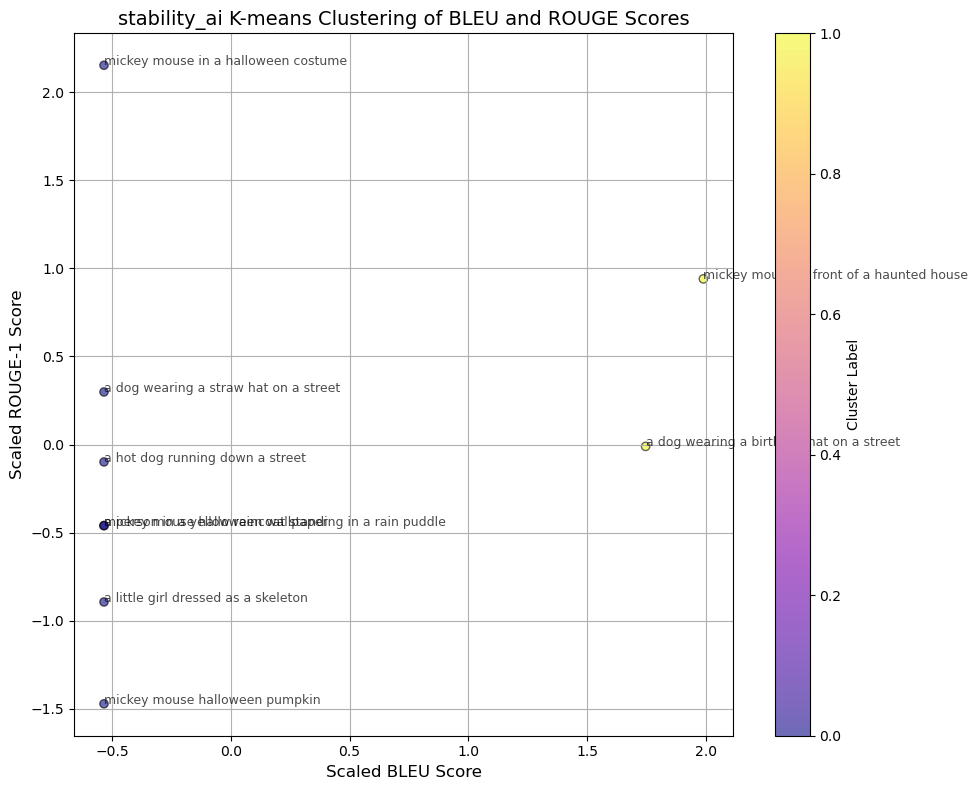

<Figure size 640x480 with 0 Axes>

In [16]:
df = pd.read_csv('image_generation_results.csv')

# Create array of reference prompts
reference_captions = df["Prompt"].tolist()

# Create array of generated captions
generated_captions = df["Stability AI Caption"].tolist()

plot_scores('stability_ai', reference_captions, generated_captions)

/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/elizayoung/.local/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

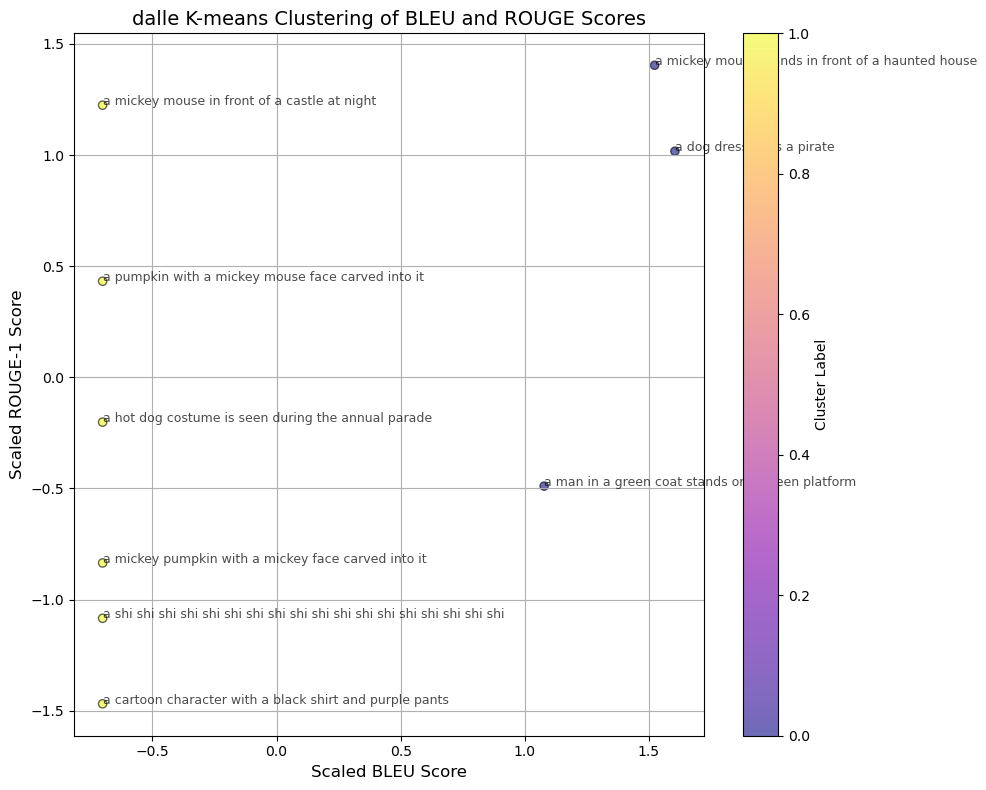

<Figure size 640x480 with 0 Axes>

In [17]:
# Create array of generated captions
generated_captions = df["Dall-E Caption"].tolist()

plot_scores('dalle', reference_captions, generated_captions)

Output results to file

In [80]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load dataframe
df = pd.read_csv('image_generation_results.csv')

# Check for 'User Preference'
if 'User Preference' not in df.columns:
    raise ValueError("User Preference column not found in the DataFrame.")

# Flatten ROUGE score tuples if needed
def flatten_rouge(record):
    # Evaluate the string into a Python dictionary
    data_dict = eval(record.replace('Score', 'dict'))

    # Extract the fmeasure values from the dictionary
    fmeasure_values = {k: v['fmeasure'] for k, v in data_dict.items()}

    return fmeasure_values

# Extract and flatten ROUGE scores
rouge_stability = pd.DataFrame(df['Stability AI Rouge'].apply(flatten_rouge).tolist(), index=df.index)
rouge_dalle = pd.DataFrame(df['Dall-E Rouge'].apply(flatten_rouge).tolist(), index=df.index)

# Print shapes of the flattened scores
print(f"Stability AI Rouge shape: {rouge_stability.shape}")
print(f"Dall-E Rouge shape: {rouge_dalle.shape}")

# Ensure we have the correct number of columns
if rouge_stability.shape[1] != 3 or rouge_dalle.shape[1] != 3:
    raise ValueError("Expected 3 columns for ROUGE scores but got different numbers.")

# Add flattened scores back to DataFrame
df[['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL']] = rouge_stability
df[['Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL']] = rouge_dalle

# Select features and target variable
features = ['Stability AI Rouge1', 'Stability AI Rouge2', 'Stability AI RougeL',
            'Dall-E Rouge1', 'Dall-E Rouge2', 'Dall-E RougeL',
            'Stability AI BLEU', 'Dall-E BLEU']

# Remove any rows with NaN values
X = df[features].dropna()
y = df.loc[X.index, 'User Preference']

# Check if X and y are empty
if X.empty or y.empty:
    print("No data available for training.")
    print(f"Shape of features: {X.shape}, Shape of target: {y.shape}")
else:
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Fit Random Forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))


Stability AI Rouge shape: (9, 3)
Dall-E Rouge shape: (9, 3)
              precision    recall  f1-score   support

stability_ai       1.00      1.00      1.00         2

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2

